In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

# Preparing Data

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100

# proportion of validation set to training set
valid_size = 0.2  # DO NOT MODIFY !!!

# convert data to torch.FloatTensor
train_tfms = transforms.ToTensor()
valid_tfms = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=train_tfms)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=valid_tfms)

# split the training dataset into training set and validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# FashionMNIST Dataset

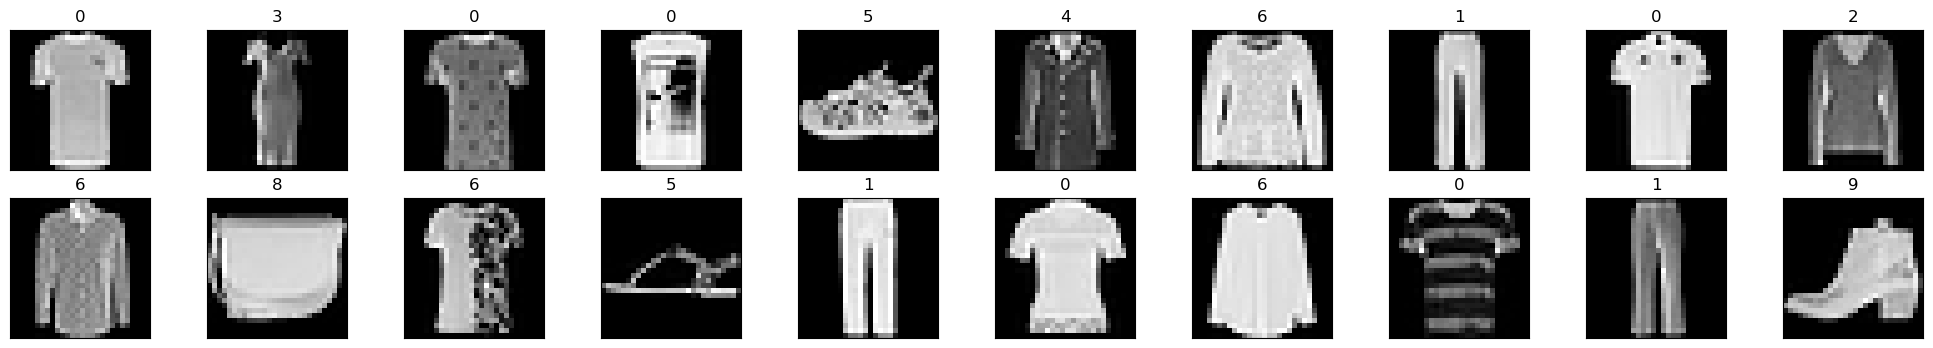

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# Model Architecture

In [10]:
## define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layers
        self.fc1 = nn.Linear(28 * 28, 512) # DO NOT MODIFY !!!
        self.fc2 = nn.Linear(512, 256)    # DO NOT MODIFY !!!
        self.fc3 = nn.Linear(256, 10)    # DO NOT MODIFY !!!
        # self.dropout = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)      # DO NOT MODIFY !!!
        x = self.fc1(x)           # DO NOT MODIFY !!!
        # add hidden layer, with relu activation function
        n = nn.BatchNorm1d(512)
        x = n(x)
        x = self.dropout(F.relu(x))
        x = self.fc2(x)           # DO NOT MODIFY !!!
        n = nn.BatchNorm1d(256)
        x = n(x)
        x = self.dropout(F.relu(x))
        x = self.fc3(x)           # DO NOT MODIFY !!!
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


# Hyperparameters

In [16]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# number of epochs to train the model
n_epochs = 10  # DO NOT MODIFY !!!

# specify optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015/0.7, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0035, steps_per_epoch=len(train_loader), epochs=n_epochs, div_factor=0.7, final_div_factor=100, pct_start=0.4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*n_epochs, eta_min=0.0015/80)

# Training and Validation

In [17]:
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
# initialize history for recording what we want to know
history = []

for epoch in range(n_epochs):
    # monitor training loss, validation loss and learning rate
    train_loss = 0.0
    valid_loss = 0.0
    lrs    = []
    result = {'train_loss': [], 'val_loss': [], 'lrs': []}

    # prepare model for training
    model.train()

    #######################
    # train the model #
    #######################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        scheduler.step()

        # record learning rate
        lrs.append(optimizer.param_groups[0]['lr'])

        # update running training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data,target in valid_loader:
        # compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,target)
        # update running validation loss
        valid_loss += loss.item()*data.size(0)

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    result['train_loss'] = train_loss
    valid_loss = valid_loss/len(valid_loader.dataset)
    result['val_loss'] = valid_loss
    leaning_rate = lrs
    result['lrs'] = leaning_rate
    history.append(result)

    print('Epoch {:2d}: Learning Rate: {:.6f} Training Loss: {:.6f} Validation Loss:{:.6f}'.format(
        epoch+1,
        leaning_rate[-1],
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased({:.6f}-->{:.6f}). Saving model ..".format(
        valid_loss_min,
        valid_loss
        ))
        torch.save(model.state_dict(),"model.pt")
        valid_loss_min = valid_loss

Epoch  1: Learning Rate: 0.004780 Training Loss: 0.235543 Validation Loss:0.071607
Validation loss decreased(inf-->0.071607). Saving model ..
Epoch  2: Learning Rate: 0.004249 Training Loss: 0.211527 Validation Loss:0.072678
Epoch  3: Learning Rate: 0.003719 Training Loss: 0.188811 Validation Loss:0.065625
Validation loss decreased(0.071607-->0.065625). Saving model ..
Epoch  4: Learning Rate: 0.003500 Training Loss: 0.173893 Validation Loss:0.062612
Validation loss decreased(0.065625-->0.062612). Saving model ..
Epoch  5: Learning Rate: 0.003268 Training Loss: 0.160663 Validation Loss:0.066513
Epoch  6: Learning Rate: 0.002636 Training Loss: 0.151056 Validation Loss:0.064791
Epoch  7: Learning Rate: 0.001773 Training Loss: 0.127643 Validation Loss:0.066128
Epoch  8: Learning Rate: 0.000911 Training Loss: 0.109631 Validation Loss:0.064456
Epoch  9: Learning Rate: 0.000280 Training Loss: 0.091080 Validation Loss:0.064199
Epoch 10: Learning Rate: 0.000050 Training Loss: 0.080729 Validati

# Plot Learning Rate Curve

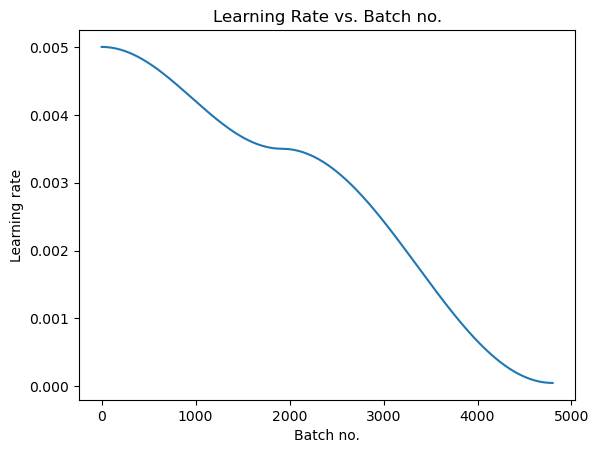

In [18]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

# Plot Loss Curve

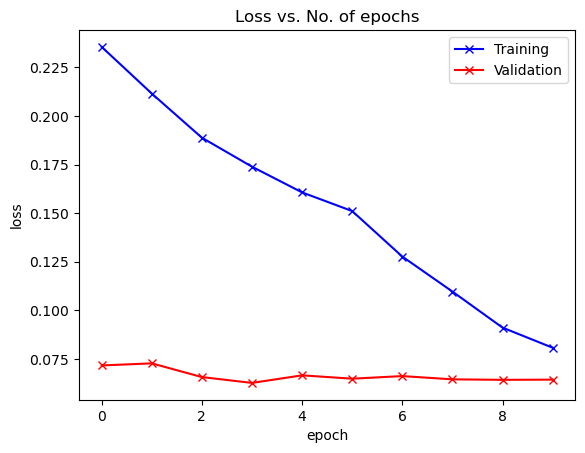

In [19]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Testing

In [20]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# prep model for evaluation
model.eval()

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of Class %5s: %2.2f%% (%2d/%2d)' % (
            str(i),
            100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i])
            ))
    else:
        print('Test Accuracy of Class %5s: N/A (no training examples)' % (str[i]))

print('\nTest Accuracy (Overall): %2.2f%% (%2d/%2d)' % (
    100 * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct),
    np.sum(class_total)
    ))

Test Loss: 0.336408

Test Accuracy of Class     0: 85.20% (852/1000)
Test Accuracy of Class     1: 98.00% (980/1000)
Test Accuracy of Class     2: 83.10% (831/1000)
Test Accuracy of Class     3: 91.10% (911/1000)
Test Accuracy of Class     4: 83.70% (837/1000)
Test Accuracy of Class     5: 96.70% (967/1000)
Test Accuracy of Class     6: 73.50% (735/1000)
Test Accuracy of Class     7: 95.90% (959/1000)
Test Accuracy of Class     8: 98.00% (980/1000)
Test Accuracy of Class     9: 95.90% (959/1000)

Test Accuracy (Overall): 90.11% (9011/10000)
